In [171]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from os import listdir as ls
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import albumentations as alb

plt.ion()
alb

<module 'albumentations' from '/home/semyon/anaconda3/envs/myenv/lib/python3.6/site-packages/albumentations/__init__.py'>

In [63]:
df = pd.read_csv('dataset/chestnet_labels_sample.csv')
df.head()

,Name,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,IsPathology
0,00000013_005.png,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1
1,00000013_026.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,00000017_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,00000032_001.png,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 16 columns):
Name                  5606 non-null object
Atelectasis           5606 non-null int64
Cardiomegaly          5606 non-null int64
Effusion              5606 non-null int64
Infiltration          5606 non-null int64
Mass                  5606 non-null int64
Nodule                5606 non-null int64
Pneumonia             5606 non-null int64
Pneumothorax          5606 non-null int64
Consolidation         5606 non-null int64
Edema                 5606 non-null int64
Emphysema             5606 non-null int64
Fibrosis              5606 non-null int64
Pleural_Thickening    5606 non-null int64
Hernia                5606 non-null int64
IsPathology           5606 non-null int64
dtypes: int64(15), object(1)
memory usage: 700.8+ KB


In [143]:
df.iloc[1, 1:-1].values.astype(int)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [66]:
image_name = df.iloc[67,0]
image_name = os.path.join('dataset/images', image_name)
img = Image.open(image_name)
print(img)
img = np.array(img)
img.shape

<PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x7FC40FC79278>


(1024, 1024)

In [172]:
class ChestnetDataset(Dataset):
    """Chest X-ray picture dataset annotated with patologies"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        TODO: copy duplicate grayscake channels to get RGB
        """
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = io.imread(img_name)
        labels = self.df.iloc[idx, 1:-1].values.astype(int)
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
def show_example(example):
    """
    Show image with labels
    Args:
    example: dict or image(ndarray)
    """
    
    plt.figure()
    if isinstance(example, dict):
        image = example['image']
        plt.title(str(example['labels']))
    else:
        image = example
    plt.imshow(image, cmap='gray')
    plt.show()    

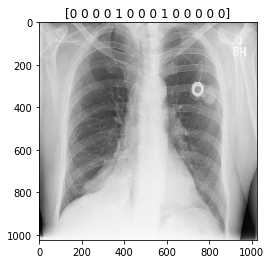

In [173]:
ds = ChestnetDataset('dataset/chestnet_labels_sample.csv', 'dataset/images/')
show_example(ds[5])

In [174]:
img = ds[1]['image']
h,w = img.shape[:2]
h, w

(1024, 1024)

In [186]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image = transform.resize(image, (new_h, new_w))
        return {'image': image, 'labels': labels}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return {'image': torch.from_numpy(sample['image']),
                'labels': torch.from_numpy(sample['labels'])}

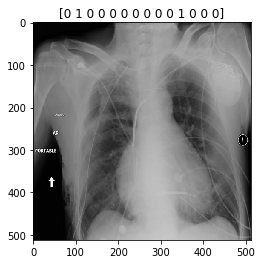

{'image': tensor([[0.0088, 0.0098, 0.0098,  ..., 0.0245, 0.0108, 0.0039],
         [0.0108, 0.0147, 0.0157,  ..., 0.0431, 0.0225, 0.0069],
         [0.0118, 0.0157, 0.0157,  ..., 0.0529, 0.0294, 0.0118],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.1588, 0.2147, 0.2010],
         [0.0059, 0.0069, 0.0078,  ..., 0.1451, 0.2098, 0.2039],
         [0.0039, 0.0059, 0.0078,  ..., 0.1020, 0.1500, 0.1588]],
        dtype=torch.float64),
 'labels': tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])}

In [187]:
scale = Rescale(512)
show_example(scale(ds[1]))
to_tensor = ToTensor()
to_tensor(scale(ds[1]))



In [177]:
transformed_dataset = ChestnetDataset('dataset/chestnet_labels_sample.csv', 'dataset/images/',
                                           transform=transforms.Compose([
                                               Rescale(512),
                                               ToTensor()
                                           ]))

In [178]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [179]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['labels']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

0 torch.Size([4, 1024, 1024]) torch.Size([4, 14])
1 torch.Size([4, 1024, 1024]) torch.Size([4, 14])
2 torch.Size([4, 1024, 1024]) torch.Size([4, 14])
3 torch.Size([4, 1024, 1024]) torch.Size([4, 14])


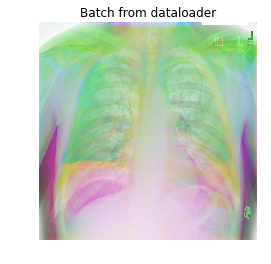

In [188]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['labels'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break